In [103]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
import scipy.integrate as I
import astropy.units as u

Read in and process dataset for photon flux.

In [104]:
dir = pd.read_csv('./Blackhawk/results//test/photon_primary_spectrum.txt', sep = '    ', skiprows=1)
frag = pd.read_csv('./BlackHawk/results/test/photon_secondary_spectrum.txt', sep = '    ', skiprows=1)

# Stefano's dataset
hardness = pd.read_csv('./Blackhawk/t90_hardness_ratio/hardnessratios.tex', sep='\t')

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [105]:
# 20MeV to 100GeV
LAT_energy = (20 * 1e-3, 300)
# 8 keV to 100MeV
GBM_energy = (200 * 1e-6, 40 * 1e-3)
BGO_energy = (8 * 1e-6, 10 * 1e-3)


time = hardness['Time to Death']

In [106]:
dir = dir.set_index('time/energy')
frag = frag.set_index('time/energy')

def generate_lightcurve(dir, frag, energy_range):

    dir = dir.loc[:, (dir.columns.astype('float64') > energy_range[0])]
    dir = dir.loc[:, (dir.columns.astype('float64') < energy_range[1])]

    frag = frag.loc[:, (frag.columns.astype('float64') > energy_range[0])]
    frag = frag.loc[:, (frag.columns.astype('float64') < energy_range[1])]

    lc_dir = [I.simps(x=dir.columns.astype('float64'), y=dir.iloc[i].to_list()) for i in range(dir.shape[0])]

    lc_frag = [I.simps(x=frag.columns.astype('float64'), y=frag.iloc[i].to_list()) for i in range(frag.shape[0])]

    return np.add(lc_dir, lc_frag)


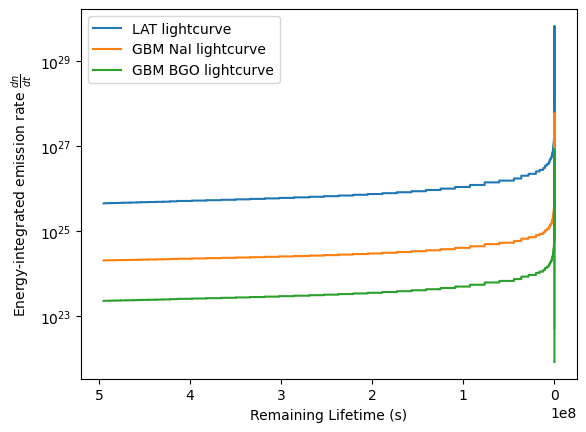

In [107]:
lat_lc = generate_lightcurve(dir, frag, LAT_energy)
gbm_lc = generate_lightcurve(dir, frag, GBM_energy)
bgo_lc = generate_lightcurve(dir, frag, BGO_energy)

d = lambda f, sens = 1e-9: np.sqrt( (1/sens) * u.cm**2 * u.s * f / (4*3.14159) )

lat_d = d(lat_lc/u.s).to('pc')
gbm_d = d(gbm_lc/u.s).to('pc')
bgo_d = d(bgo_lc/u.s).to('pc')

fig, ax = plt.subplots()
#fig, axes = plt.subplots(1, 2, figsize = (12, 5))
###
#ax = axes[0]
ax.step(time, lat_lc, label = 'LAT lightcurve')
ax.step(time, gbm_lc, label = 'GBM NaI lightcurve')
ax.step(time, bgo_lc, label = 'GBM BGO lightcurve')

ax.set_yscale('log')
#ax.set_xscale('log')

lims = ax.get_xlim()
ax.set_xlim(lims[1], lims[0])
ax.legend()

ax.set_ylabel(r'Energy-integrated emission rate $\frac{dn}{dt}$')
ax.set_xlabel('Remaining Lifetime (s)')
fig.savefig('Lightcurves.png', dpi=500)

[Distance fcn.](#dist)

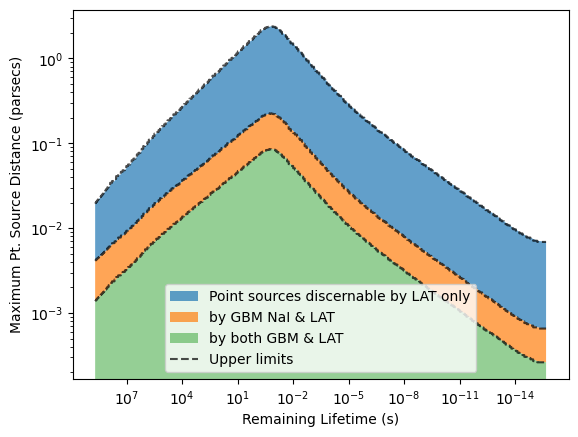

In [108]:
fig, ax = plt.subplots()
#ax = axes[1]
ax.fill_between(time, gbm_d.value, lat_d.value, alpha = 0.7, label = 'Point sources discernable by LAT only')
ax.fill_between(time, y1=bgo_d.value, y2=gbm_d.value, alpha = 0.7, label = 'by GBM NaI & LAT')
ax.fill_between(time, bgo_d.value, alpha=0.5, label = 'by both GBM & LAT')
ax.step( time, lat_d, color = 'black', linestyle='--', alpha = 0.7)# , '-' , label = 'Max distance for photon detection (LAT)')
ax.step( time, gbm_d, color = 'black', linestyle='--', alpha = 0.7, label = 'Upper limits')# , '-' , label = 'Max distance for photon detection (GBM)')
ax.step( time, bgo_d, color = 'black', linestyle='--', alpha = 0.7)
#ax.axhline(0.015, linestyle='-.', color='darkred', label = '0.015 pc', alpha=0.5)

ax.legend()
ax.set_yscale('log')
ax.set_xscale('log')

lims = ax.get_xlim()
ax.set_xlim(lims[1], lims[0])

ax.set_ylabel('Maximum Pt. Source Distance (parsecs)')
ax.set_xlabel('Remaining Lifetime (s)')
fig.savefig('DistFuncs.png', dpi=500)

In [336]:
# def calculate_inflection_ratio(lightcurve):

#     peak_index = list(lightcurve).index(lightcurve.max())

#     pre = I.simps(x = time[:peak_index], y = lightcurve[:peak_index])

#     post = I.simps(x = time[peak_index:], y = lightcurve[peak_index:])

#     return pre, post

# for lc in [lat_lc, gbm_lc, bgo_lc]:
#     pre, post = calculate_inflection_ratio(lc)
#     print('%s / %s = %s'%(pre, post, pre/post))

[Hardness](#hd)

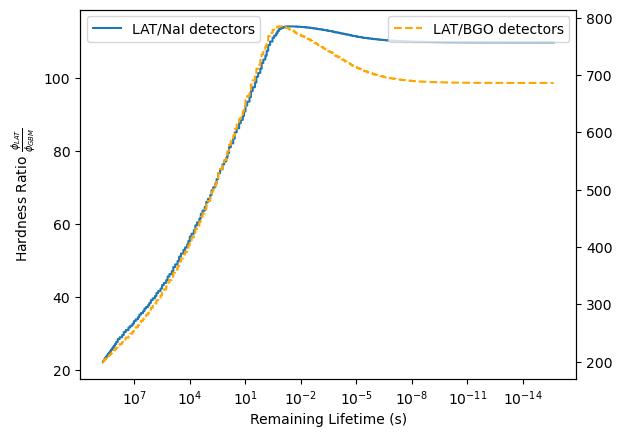

In [110]:
fig, ax = plt.subplots()

ax.step(time, np.divide(lat_lc,gbm_lc), label = 'LAT/NaI detectors')
ax2 = ax.twinx()
ax2.step(time, np.divide(lat_lc,bgo_lc), label = 'LAT/BGO detectors', color = 'orange', linestyle='--')

ax.set_xscale('log')
#ax.set_yscale('log')

lims = ax.get_xlim()
ax.set_xlim(lims[1], lims[0])

ax.legend()
ax2.legend()
ax.set_ylabel(r'Hardness Ratio $\frac{\phi_{LAT}}{\phi_{GBM}}$')
ax.set_xlabel('Remaining Lifetime (s)')
fig.savefig('Hardness.png', dpi = 500)

[Finding T90s](#T90)

In [337]:
# This function exists only because the time interval contains a bunch of duplicates with different y-values
# If time has values x1=x2 with different values y1!=y2, this function simply looks for the nearest x3!=x1 and 
#   computes the trapezoidal area from x1 to x3

def Riemann_Integrate(x, y, threshold = np.infty, verbose = False):
    """
    Reimann Integration returning trapezoidal integration so long as cumulative sum < threshold
    Input real-valued x-,y-data as np.array
    Returns integrated value & index at which threshold was met (default infinity)

    NOTABLY: Skips over repeated x-data by taking the lowest y of repeated indices x and 
        matching it to the next non-repeating index x

    Eventually I could also calculate this as a left- and right-hand Riemann sum and be able to show an upper- 
        and lower-bound for the T90 integration. 
    But I don't really think this would be a big differencee, since it's scaled by 1e7 already.
    """

    cum_int = 0.
    i = 0
    while i != x.shape[0] - 1: # Ends when [x+j]

        # First, check for next repeated index
        j = 1
        while x[i] == x[i+j]: # Ends when next index x[i + j] != x[i]
            j+=1
            # Don't actually need this because the RHS behaves gentlemanly
            # if i+j > x.shape[0]: # If we just get to the end of the array
            #     break
        

        # Dimensions
        dy = y[i + j] - y[i]
        dx = np.abs( x[i + j] - x[i] )

        # Calculate area
        area = dx * dy # Square
        area += 0.5 * dx * dy # Triangle

        # Sum up to cumulative integral
        cum_int += area

        if verbose:
            print('Index %s to %s: dx = x[i+j] %s - x[i] %s and dy = y[i+j] %s - y[i] %s to running total %s'%
                (i, j, x[i+j], x[i], y[i+j], y[i], cum_int))

        # Update index
        i += j

        if threshold <= cum_int:
            # Break if sum meets threshold
            return cum_int, i

    # Return cumulative sum the index stopped on
    return cum_int, i

In [352]:
# Point source sensitivity
sens = 10**-9 /u.s /u.cm**2

# Note also that the "time" variable is a global variable = your "Time to Death" array from Mathematica

lat_d = d(lat_lc/u.s).to('pc')
gbm_d = d(gbm_lc/u.s).to('pc')
bgo_d = d(bgo_lc/u.s).to('pc')

def calculate_t90(distances, lightcurve, ratio = 1e-1):
    """
    Input an arbitrary array of distances d & the lightcurve. Determine a cutoff ratio (default 10% total flux).
    Returns an array of T90s corresponding to the distances array


    ALGORITHM:

    We know that the T90 for an EBH is bounded to the right by a sharp cutoff.
    i.e. T95 is virtually = T100

    for each given distance d (arbitrary range)

        Impose a mininum flux cutoff for the fluxes which reach the telescope (according to sensitivity)

        Integrate for the total flux

        Compute the index at which the cumulative flux = 10% total flux (see Riemann_Integrate)

        T90 = remaining time at t break - final time
    """

    t90 = []
    for dist in distances: # All distances corresponding to >1ms of remaining BH lifetime
        
        # Min flux at a given distance to be detected is \phi = sens * 4pi d^2
        minimum_flux = 4 * 3.14159 * dist.to('cm').value**2 * sens.value # Unit conversion, because below I input an astropy array in parsecs

        # Impose that only fluxes > minimum_flux are included in computation
        interval = np.where(lightcurve > minimum_flux)[0] 

        if interval.shape[0] != 0: # As long as the flux is at all visible.

            # Calculat the total flux across the interval
            total_flux = Riemann_Integrate( x = np.array(time[interval]), \
                y = lightcurve[interval] )[0] # Index 0 is the integral-value
            
            # Integrate again, but this time, stop when flux > 10% of total flux
            i = Riemann_Integrate( x = np.array(time[interval]), \
                y = lightcurve[interval], \
                threshold = ratio*total_flux )[1] # Index 1 is the index-value where 10% total flux is achieved
            
            # The remaining lifetime from the stopping index to the end of the allowed interval is the T90)
            t90.append( time[interval].to_list()[i] - time[interval].to_list()[-1])

        else:
            t90.append(0.) # If flux is invisible, T90 is 0.

    return t90

Time at peak flux: 0.1520


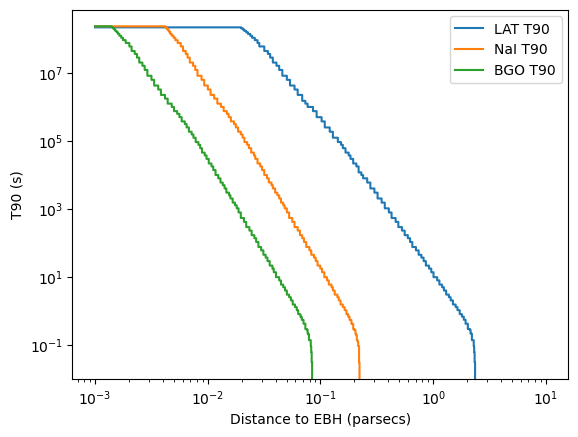

In [390]:
# We have the integrated LAT lightcurves from earlier: lat_lc, gbm_lc (corresponding to NaI) and bgo_lc

print('Time at peak flux: %.4f'%time[list(lat_lc).index(lat_lc.max())])

d_range = np.logspace(-3, 1, base = 10, num = 1000)*u.pc
# lat_d_range = lat_d[np.where(time>0.152)]

lat_t90 = calculate_t90(d_range, lat_lc)

# Do the same for each detector
# gbm_d_range = gbm_d[np.where(time>0.152)] 
gbm_t90 = calculate_t90(d_range, gbm_lc)

# bgo_d_range = bgo_d[np.where(time>0.152)]
bgo_t90 = calculate_t90(d_range, bgo_lc)

# Plot
fig, ax = plt.subplots()
ax.step(d_range, lat_t90, label = 'LAT T90')
ax.step(d_range, gbm_t90, label = 'NaI T90')
ax.step(d_range, bgo_t90, label = 'BGO T90')
#plt.axvline(0.015, color = 'black', linestyle='dashed', alpha=0.5, label = '0.015 pc')

ax.set_xlabel('Distance to EBH (parsecs)')
ax.set_ylabel('T90 (s)')

ax.legend()
ax.set_yscale('log')
ax.set_xscale('log')

fig.savefig('T90s.png', dpi=500)

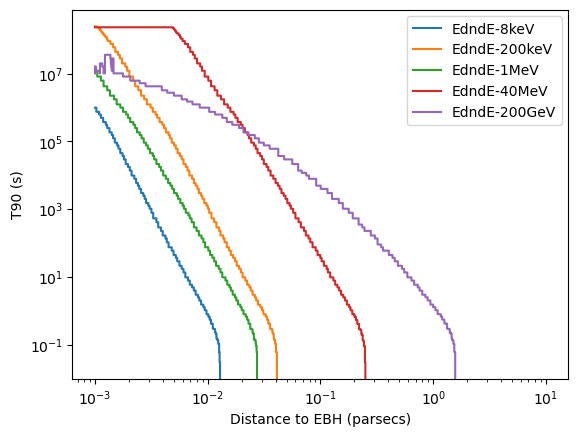

In [382]:
# BONUS: here's the same T90 calculation on your SED curves

fig, ax = plt.subplots()

for energy_bin in ['EdndE-8keV', 'EdndE-200keV', 'EdndE-1MeV', 'EdndE-40MeV', 'EdndE-200GeV']:

    d_range = np.logspace(-3, 1, base = 10, num = 1000)*u.pc
    t90 = calculate_t90(
        d_range, np.array(hardness[energy_bin])
    )
    ax.step(d_range, t90, label = energy_bin)

ax.set_xlabel('Distance to EBH (parsecs)')
ax.set_ylabel('T90 (s)')

ax.legend()
ax.set_yscale('log')
ax.set_xscale('log')

T90/T50 could be a good proxy for the index.

We model the Blackhawk lightcurve with a powerlaw.
For remaining lifetime $\tau = t$, the flux is modelled by a powerlaw with an index $|i|$: $F(t) = t^{-i}$

Allow $t_d$ to be the instant at which the minimum flux is met \& the photon lightcurve becomes observable (== the T0). 

Total Flux = $\int_{t_d}^0 t^{-i}dt = \frac{t^{1-i}}{1-i}|_{t_d}^0$

The T90 is determined by the relationship:
$$\int_{T90}^0 t^{-i} = 0.9 \times \int_{t_d}^0 t^{-i}$$
$$T90 = 0.9^{\frac{1}{1-i}}t_d$$

Similarly, the T50 is:
$$T50 =  0.5^{\frac{1}{1-i}}t_d$$

Such that
$$\frac{T90}{T50} = (\frac{9}{5})^{\frac{1}{1-i}}$$ 

Text(0, 0.5, 'Theoretical T90/T50 ratio')

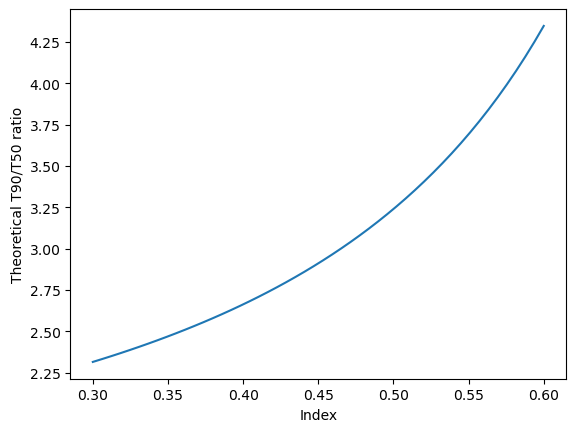

In [400]:
indices = np.linspace(0.3,0.6)
Tdiv = lambda index: (9/5)**(1/(1-index))
plt.plot(indices, Tdiv(indices))
plt.xlabel('Index')
plt.ylabel('Theoretical T90/T50 ratio')

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Text(0.5, 1.0, 'T90 / T50')

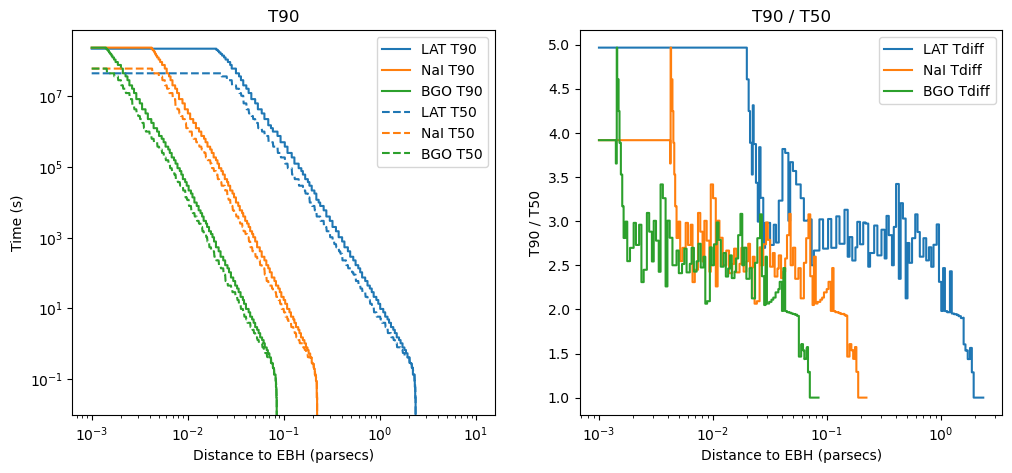

In [391]:
# T90/T50 could be a way to cross-validate with normalization for the distance from the EBH.
# It could also be used as a proxy for index.

lat_t50 = calculate_t90(d_range, lat_lc, ratio = .5)
gbm_t50 = calculate_t90(d_range, gbm_lc, ratio = .5)
bgo_t50 = calculate_t90(d_range, bgo_lc, ratio = .5)

fig, axes = plt.subplots(1, 2, figsize = (12,5))

ax = axes[0]
ax.step(d_range, lat_t90, label = 'LAT T90')
ax.step(d_range, gbm_t90, label = 'NaI T90')
ax.step(d_range, bgo_t90, label = 'BGO T90')
#plt.axvline(0.015, color = 'black', linestyle='dashed', alpha=0.5, label = '0.015 pc')

ax.plot(d_range, lat_t50, label = 'LAT T50', linestyle='--', color='C0')
ax.plot(d_range, gbm_t50, label = 'NaI T50', linestyle='--', color='C1')
ax.plot(d_range, bgo_t50, label = 'BGO T50', linestyle='--', color='C2')

ax.set_xlabel('Distance to EBH (parsecs)')
ax.set_ylabel('Time (s)')

ax.legend()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_title('T90')

ax = axes[1]
ax.step(d_range, np.divide(lat_t90, lat_t50), label = 'LAT Tdiff')
ax.step(d_range, np.divide(gbm_t90, gbm_t50), label = 'NaI Tdiff')
ax.step(d_range, np.divide(bgo_t90, bgo_t50), label = 'BGO Tdiff')

ax.set_xlabel('Distance to EBH (parsecs)')
ax.set_ylabel('T90 / T50')

ax.legend()
# ax.set_yscale('log')
ax.set_xscale('log')
ax.set_title('T90 / T50')

In [334]:
# fig, axes = plt.subplots(1,2, figsize = (12,6))

# ax = axes[0]
# ax.step(lat_d_range, (lat_lc.max()/(4*3.14159*lat_d_range**2)), label = 'LAT')
# ax.step(gbm_d_range, (gbm_lc.max()/(4*3.14159*gbm_d_range**2)), label = 'NaI')
# ax.step(bgo_d_range, (bgo_lc.max()/(4*3.14159*bgo_d_range**2)), label = 'BGO')

# ax.set_yscale('log')
# ax.set_xscale('log')

# ax.set_xlabel('Distances (parsecs)')
# ax.set_ylabel('Peak flux (/s)')

# ax = axes[1]
# ax.step(lat_d_range, lat_t90*(lat_lc.max()/(4*3.14159*lat_d_range**2)), label = 'LAT')
# ax.step(gbm_d_range, gbm_t90*(gbm_lc.max()/(4*3.14159*gbm_d_range**2)), label = 'NaI')
# ax.step(bgo_d_range, bgo_t90*(bgo_lc.max()/(4*3.14159*bgo_d_range**2)), label = 'BGO')

# ax.set_yscale('log')
# ax.set_xscale('log')

# ax.set_xlabel('Distances (parsecs)')
# ax.set_ylabel(r'Peak Flux*T90 (unitless)')#($s^{2}$)')

[Calculating energy spectrum](#es)

In [335]:
# spectrum_dir = {}
# for energy in dir.columns:
#     # time-interate dir
#     spectrum_dir[energy] =  I.simps(y = dir[energy].astype('float64').to_list(), x = dir.index.astype('float64')) 

# spectrum_frag = {}
# for energy in frag.columns:
#     spectrum_frag[energy] = I.simps(y = frag[energy].to_list(), x = frag.index) 

[Fitting Lightcurves](#lc)

In [60]:
from scipy.optimize import curve_fit

plaw = lambda x,N,index,offset,interc: N*((x-offset)**index) + interc

lat_lc = generate_lightcurve(dir, frag, LAT_energy)
gbm_lc = generate_lightcurve(dir, frag, GBM_energy)
bgo_lc = generate_lightcurve(dir, frag, BGO_energy)

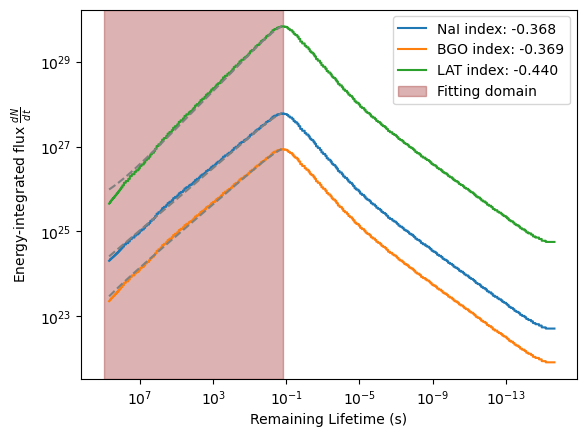

In [90]:
time_max = 1e9

fig, ax = plt.subplots()

### GBM NaI
filter = np.where(time[:list(gbm_lc).index(gbm_lc.max())] < time_max)[0]
ydata = gbm_lc[filter]
xdata = time[filter]
 
params, cov = curve_fit( xdata = xdata, ydata = ydata, f = plaw,
   p0 = [1e29, -0.52, 0, 1e29], bounds = (-np.inf, np.inf))

ax.step(time, gbm_lc, label = 'NaI index: %.3f'%params[1])
ax.plot(xdata, plaw(xdata, *params), '--', color = 'grey')

### GBM BGO
filter = np.where(time[:list(bgo_lc).index(bgo_lc.max())] < time_max)[0]
ydata = bgo_lc[filter]
xdata = time[filter]
 
params, cov = curve_fit( xdata = xdata, ydata = ydata, f = plaw,
   p0 = [1e29, -0.52, 0, 1e29], bounds = (-np.inf, np.inf))

ax.step(time, bgo_lc, label = 'BGO index: %.3f'%params[1])
ax.plot(xdata, plaw(xdata, *params), '--', color = 'grey')

### LAT
filter = np.where(time[:list(lat_lc).index(lat_lc.max())] < time_max)[0]
ydata = lat_lc[filter]
xdata = time[filter]
 
params, cov = curve_fit( xdata = xdata, ydata = ydata, f = plaw,
   p0 = [1e29, -0.52, 0, 1e29], bounds = (-np.inf, np.inf))

ax.step(time, lat_lc, label = 'LAT index: %.3f'%params[1])
ax.plot(xdata, plaw(xdata, *params), '--', color = 'grey')


ax.axvspan(time[list(lat_lc).index(lat_lc.max())], time_max, color = 'darkred', alpha = .3, label = 'Fitting domain')

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()

lims = ax.get_xlim()
ax.set_xlim(lims[1], lims[0])


ax.set_ylabel(r'Energy-integrated flux $\frac{dN}{dt}$')
ax.set_xlabel('Remaining Lifetime (s)')

fig.savefig('FitPowerlaw_ranges.png',dpi=500)

----

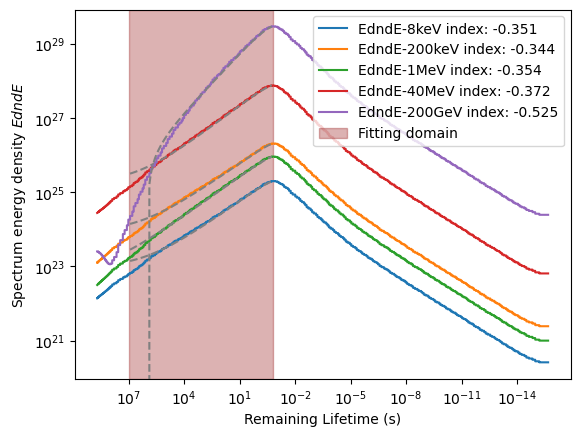

In [91]:
time_max = 1e7

fig, ax = plt.subplots()

for energy_bin in ['EdndE-8keV', 'EdndE-200keV', 'EdndE-1MeV', 'EdndE-40MeV', 'EdndE-200GeV']:
    lc = hardness[energy_bin]
    filter = np.where(time[:list(lc).index(lc.max())] < time_max)[0]
    ydata = lc[filter]
    xdata = time[filter]
    
    params, cov = curve_fit( xdata = xdata, ydata = ydata, f = plaw,
    p0 = [1e29, -0.52, 0, 1e29], bounds = (-np.inf, np.inf))

    ax.step(time, hardness[energy_bin], label = '%s index: %.3f'%(energy_bin,params[1]))
    ax.plot(xdata, plaw(xdata, *params), '--', color = 'grey')

ax.axvspan(time[list(lat_lc).index(lat_lc.max())], time_max, color = 'darkred', alpha = .3, label = 'Fitting domain')

# ax.step(hardness['Time to Death'], hardness['EdndE-8keV'], label = '8keV')
# ax.step(hardness['Time to Death'], hardness['EdndE-200keV'], label = '200keV')
# ax.step(hardness['Time to Death'], hardness['EdndE-1MeV'], label = '1MeV')
# ax.step(hardness['Time to Death'], hardness['EdndE-40MeV'], label = '40MeV')
# ax.step(hardness['Time to Death'], hardness['EdndE-200GeV'], label = '200GeV')

#plt.xlim(1e5,1e-3)
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()

lims = ax.get_xlim()
ax.set_xlim(lims[1], lims[0])

ax.set_ylabel(r'Spectrum energy density $EdndE$')
ax.set_xlabel('Remaining Lifetime (s)')

fig.savefig('FitPowerlaw_energies.png',dpi=500)